In [1]:
#####################
# IMPORT LIBS
#####################

import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = False
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [2]:
###############
# Config
###############

n_seed = 5
n_fold = 5
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [3]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [4]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

In [5]:
payments = payments.sort_values(by='day_dt', ascending = False).reset_index(drop = True)

In [6]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['number_of_deals'] = data['client_id'].map(deals.groupby('client_id')['crncy_cd'].count()).fillna(0)
    data['mean_deal_sum'] = data['client_id'].map(deals.groupby('client_id')['agrmnt_sum_rur'].mean()).fillna(0)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [7]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [8]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_payments(data)

In [9]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [10]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [11]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [12]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [13]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [14]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [15]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [16]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [17]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [18]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [19]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [20]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [21]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [22]:
public_score, private_score = local_scorer.get_score(test_funnel, np.mean(oof, axis = 1), Y_test)

In [23]:
data

                 client_id  sale_flg  sale_amount  contacts  feature_1  \
0      7513301859607023584         0          NaN         1          7   
1      9157009756404187626         0          NaN         1          3   
2     -1893104556496814867         0          NaN         1          5   
3      6886062013213911831         0          NaN         1          4   
4     -8156468515495593794         1    138018.05         1          7   
...                    ...       ...          ...       ...        ...   
21493  4662551505651924284         0          NaN         2          3   
21494 -8968737688687691353         0          NaN         1          9   
21495 -5799097497074119478         0          NaN         1          2   
21496 -2264802671063321355         1     43882.85         2          8   
21497  -174115151336149439         0          NaN         1          3   

       client_segment  feature_2  feature_3  feature_4  feature_5  ...  \
0                13.0   571533.0    1

In [24]:
## import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

In [25]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [26]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
        if feature_1 != feature_2:
            data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
            data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
            data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
            data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [27]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_payments(data)

In [28]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [29]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [30]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [31]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [32]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [33]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [34]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [35]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [36]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [37]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [38]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [39]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [40]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [41]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

In [42]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:20, 0].values

array(['city', 'education', 'client_segment', 'region', 'age',
       'feature_7 / feature_10', 'feature_4 / feature_6',
       'feature_2 * feature_9', 'region_cd', 'feature_7 - feature_8',
       'feature_6 * feature_7', 'feature_8 / feature_7',
       'feature_4 + feature_5', 'feature_1 * feature_9',
       'feature_8 / feature_10', 'feature_1 / feature_9',
       'feature_7 / feature_8', 'feature_2 / feature_6',
       'feature_1 * feature_5', 'feature_2 / feature_5'], dtype=object)

In [43]:
X = X[['city', 'education', 'client_segment', 'region', 'age',
       'feature_7 / feature_10', 'feature_4 / feature_6',
       'feature_2 * feature_9', 'region_cd', 'feature_7 - feature_8',
       'feature_6 * feature_7', 'feature_8 / feature_7',
       'feature_4 + feature_5', 'feature_1 * feature_9',
       'feature_8 / feature_10', 'feature_1 / feature_9',
       'feature_7 / feature_8', 'feature_2 / feature_6',
       'feature_1 * feature_5', 'feature_2 / feature_5']]

In [44]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [45]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [46]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [47]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [48]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [49]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [50]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [51]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [52]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [53]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [54]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [55]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [56]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.15).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [57]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [58]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [59]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [60]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.19).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [61]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [62]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [63]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [64]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [65]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [66]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [67]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [68]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [69]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [70]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_payments(data)

In [71]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [72]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [73]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [74]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [75]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [76]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [77]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [78]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [79]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.18).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [80]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [81]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [82]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [83]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > 0.2).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [84]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [85]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [86]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [87]:
#####################
# IMPORT LIBS
#####################

import pandas as pd
import numpy as np
from pathlib import Path
import wandb
import datetime
import os
import random
import joblib
import shutil

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scoring import local_scorer
import scipy

from lightgbm import LGBMClassifier


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH 

TARGET_COLUMNS = ['sale_flg', 'sale_amount', 'contacts']
FIXED_SEEDS = [948, 534, 432, 597, 103, 21, 2242, 17, 20, 29]

RANDOM_SEED = 4444
USE_WANDB = True
CURRENT_TIME = str(datetime.datetime.now()).replace(' ', '_').split('.')[0]

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [88]:
###############
# Config
###############

n_seed = 5
n_fold = 5
prediction_threshold = 0.2
retrain_after_valid = True
make_submission = False

In [89]:
if USE_WANDB:
    wandb.login()
    run = wandb.init(project="idao-2021-finals", name = f'{CURRENT_TIME}') # todo add config here

In [90]:
%%time

transactions = pd.read_csv(INPUT_PATH / 'trxn.csv')
assets_under_management = pd.read_csv(INPUT_PATH / 'aum.csv')
balance = pd.read_csv(INPUT_PATH / 'balance.csv')
client = pd.read_csv(INPUT_PATH / 'client.csv')
campaigns = pd.read_csv(INPUT_PATH / 'com.csv')
deals = pd.read_csv(INPUT_PATH / 'deals.csv')
dict_merchant_category_code = pd.read_csv(INPUT_PATH / 'dict_mcc.csv')
payments = pd.read_csv(INPUT_PATH / 'payments.csv')
funnel = pd.read_csv(INPUT_PATH / 'funnel.csv')
appl = pd.read_csv(INPUT_PATH / 'appl.csv')

In [91]:
payments = payments.sort_values(by='day_dt', ascending = False).reset_index(drop = True)

In [92]:
# transactions['mcc_cd'] = transactions['mcc_cd'].fillna(-2)
# transactions['txn_city'] = transactions['txn_city'].fillna('<UNK>')
# transactions['tsp_name'] = transactions['tsp_name'].fillna('<UNK>')
# transactions['txn_comment_2'] = transactions['txn_comment_2'].fillna('<UNK>')

# balance['crncy_cd'] = balance['crncy_cd'].fillna(-2)
# balance['prod_cat_name'] = balance['prod_cat_name'].fillna('<UNK>')
# balance['prod_group_name'] = balance['prod_group_name'].fillna('<UNK>')


# client = client.rename(columns={
#     'gender': 'client_gender',
#     'age': 'client_age',
#     'region': 'client_region',
#     'city': 'client_city',
#     'citizenship': 'client_citizenship',
#     'education': 'client_education',
#     'job_type': 'client_job_type'
# })
# campaigns['prod'] = campaigns['prod'].fillna('<UNK>')

In [93]:
def most_common(x, default='unknown'):
    try:
        # works faster then value_counts and pd.Series.mode
        return scipy.stats.mode(x)[0][0]
    except: 
        return default


def get_feature_total(df, col_name):
    return data['client_id'].map(df.groupby(['client_id', col_name]).size().index.get_level_values('client_id').value_counts()).fillna(0)


def get_feature_most_common(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: scipy.stats.mode(x)[0][0])).fillna(fill_na_value)


def get_feature_mean(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].mean()).fillna(fill_na_value)


def get_feature_std(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].std()).fillna(fill_na_value)


def get_feature_max_min(df, col_name, fill_na_value):
    return data['client_id'].map(df.groupby('client_id')[col_name].agg(lambda x: x.max() - x.min())).fillna(fill_na_value)


def create_features_transactions(data):
    
    data = data.copy()
    
    # transaction features
    data['total_transactions'] = data['client_id'].map(transactions.groupby('client_id').size()).fillna(0)
    data['total_cards'] = get_feature_total(transactions, 'card_id')

#     data['total_transaction_amount'] = data['client_id'].map(transactions.groupby('client_id')['tran_amt_rur'].sum()).fillna(0) # add monthly, daily, etc
    data['mean_transaction_amt'] = get_feature_mean(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    data['std_transaction_amount'] = get_feature_std(transactions, 'tran_amt_rur', -1) # add monthly, daily, etc
    
    data['total_mcc_cd'] = get_feature_total(transactions, 'mcc_cd')
    data['total_share_mcc_cd'] = (data['total_mcc_cd'] / data['total_transactions']).fillna(0)
    data['most_common_mcc_cd'] = get_feature_most_common(transactions, 'mcc_cd', -1)
    
    data['total_merchant_cd'] = get_feature_total(transactions, 'merchant_cd')
    data['total_share_merchant_cd'] = (data['total_merchant_cd'] / data['total_transactions']).fillna(0)
    data['most_common_merchant_cd'] = get_feature_most_common(transactions, 'merchant_cd', -1)
    
    data['total_txn_city'] = get_feature_total(transactions, 'txn_city')
    data['total_share_txn_city'] = (data['total_txn_city'] / data['total_transactions']).fillna(0)
    data['most_common_txn_city'] = get_feature_most_common(transactions, 'txn_city', '<unknown>')
    
    data['total_tsp_name'] = get_feature_total(transactions, 'tsp_name')
    data['total_share_tsp_name'] = (data['total_tsp_name'] / data['total_transactions']).fillna(0)
    data['most_common_tsp_name'] = get_feature_most_common(transactions, 'tsp_name', '<unknown>')
    
    data['total_txn_comment_1'] = get_feature_total(transactions, 'txn_comment_1')
    data['most_common_txn_comment_1'] = get_feature_most_common(transactions, 'txn_comment_1', '<unknown>')
    
    data['total_txn_comment_2'] = get_feature_total(transactions, 'txn_comment_2')
    data['most_common_txn_comment_2'] = get_feature_most_common(transactions, 'txn_comment_2', '<unknown>')
    
    return data


def create_features_aum(data):
    data = data.copy()
    
    data['total_aum'] = data['client_id'].map(assets_under_management.groupby('client_id').size()).fillna(0)
    
    data['total_product_code'] = get_feature_total(assets_under_management, 'product_code')
    data['most_common_product_code'] = get_feature_most_common(assets_under_management, 'product_code', '<unknown>').value_counts()
    
    data['mean_balance_rur_amt'] = get_feature_mean(assets_under_management, 'balance_rur_amt', -1)
    data['std_balance_rur_amt'] = get_feature_std(assets_under_management, 'balance_rur_amt', -1)
    data['max_min_balance_rur_amt'] = get_feature_max_min(assets_under_management, 'balance_rur_amt', -1)
    
    return data


def create_features_balance(data):
    data = data.copy()
    
    data['total_balance'] = data['client_id'].map(balance.groupby('client_id').size()).fillna(0)
    
    data['total_crncy_cd'] = get_feature_total(balance, 'crncy_cd')
    data['most_common_crncy_cd'] = get_feature_most_common(balance, 'crncy_cd', -1)
    
    data['total_eop_bal_sum_rur'] = get_feature_total(balance, 'eop_bal_sum_rur')
    data['total_share_eop_bal_sum_rur'] = (data['total_eop_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_eop_bal_sum_rur'] = get_feature_mean(balance, 'eop_bal_sum_rur', -9999)
    data['std_eop_bal_sum_rur'] = get_feature_std(balance, 'eop_bal_sum_rur', -9999)
    
    data['total_min_bal_sum_rur'] = get_feature_total(balance, 'min_bal_sum_rur')
    data['total_share_min_bal_sum_rur'] = (data['total_min_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_min_bal_sum_rur'] = get_feature_mean(balance, 'min_bal_sum_rur', -9999)
    data['std_min_bal_sum_rur'] = get_feature_std(balance, 'min_bal_sum_rur', -9999)
    
    data['total_max_bal_sum_rur'] = get_feature_total(balance, 'max_bal_sum_rur')
    data['total_share_max_bal_sum_rur'] = (data['total_max_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_max_bal_sum_rur'] = get_feature_mean(balance, 'max_bal_sum_rur', -9999)
    data['std_max_bal_sum_rur'] = get_feature_std(balance, 'max_bal_sum_rur', -9999)
    
    data['total_avg_bal_sum_rur'] = get_feature_total(balance, 'avg_bal_sum_rur')
    data['total_share_avg_bal_sum_rur'] = (data['total_avg_bal_sum_rur'] / data['total_balance']).fillna(0)
    data['mean_avg_bal_sum_rur'] = get_feature_mean(balance, 'avg_bal_sum_rur', -9999)
    data['std_avg_bal_sum_rur'] = get_feature_std(balance, 'avg_bal_sum_rur', -9999)
    data['max_min_avg_bal_sum_rur'] = get_feature_max_min(balance, 'avg_bal_sum_rur', -9999)
    
    data['total_prod_cat_name'] = get_feature_total(balance, 'prod_cat_name')
    data['most_common_prod_cat_name'] = get_feature_most_common(balance, 'prod_cat_name', '<unknown>')
    
    data['total_prod_group_name'] = get_feature_total(balance, 'prod_group_name')
    data['most_common_prod_group_name'] = get_feature_most_common(balance, 'prod_group_name', '<unknown>')
    
    return data


def create_features_client(data):
    data = data.copy()
    
    data['match_client_region-region_cd'] = (data['client_region'] == data['region_cd']).astype(int)
    data.drop('client_citizenship', axis=1)
    
    return data


def create_features_campaigns(data):
    data = data.copy()
    
    data['total_campaigns'] = data['client_id'].map(campaigns.groupby('client_id').size()).fillna(0)
    
    data['total_agr_flg'] = get_feature_total(campaigns, 'agr_flg')
    data['mean_agr_flg'] = get_feature_mean(campaigns, 'agr_flg', -1)
    
    data['total_otkaz'] = get_feature_total(campaigns, 'otkaz')
    data['mean_otkaz'] = get_feature_mean(campaigns, 'otkaz', -1)
    
    data['total_dumaet'] = get_feature_total(campaigns, 'dumaet')
    data['mean_dumaet'] = get_feature_mean(campaigns, 'dumaet', -1)
    
    data['total_ring_up_flg'] = get_feature_total(campaigns, 'ring_up_flg')
    data['most_common_ring_up_flg'] = get_feature_most_common(campaigns, 'ring_up_flg', -1)
    
    data['total_count_comm'] = get_feature_total(campaigns, 'count_comm')
    data['most_common_count_comm'] = get_feature_most_common(campaigns, 'count_comm', -1)
    
    data['total_channel'] = get_feature_total(campaigns, 'channel')
    data['most_common_channel'] = get_feature_most_common(campaigns, 'channel', '<unknown>')
    
    data['total_prod'] = get_feature_total(campaigns, 'prod')
    data['most_common_prod'] = get_feature_most_common(campaigns, 'prod', '<unknown>')
    
    return data


def create_features_deals(data):
    data = data.copy()
    
    data['number_of_deals'] = data['client_id'].map(deals.groupby('client_id')['crncy_cd'].count()).fillna(0)
    data['mean_deal_sum'] = data['client_id'].map(deals.groupby('client_id')['agrmnt_sum_rur'].mean()).fillna(0)
    
    return data


def create_features_dict_mcc(data):
    data = data.copy()
    
    return data


def create_features_payments(data):
    data = data.copy()
    
    # payments 
    data['last_known_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].iloc[0])).fillna(-1)
    data['total_recieved_salary'] = data['client_id'].map(payments.groupby('client_id').apply(lambda x: x['sum_rur'].sum())).fillna(-1)
    
    return data


def create_features_appl(data):
    data = data.copy()
    
    return data


def create_features_funnel(data):
    data = data.copy()
    
    return data

In [94]:
# data merge
data = funnel.copy()
data = funnel.merge(client, on=['client_id'])

In [95]:
for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
    data[f'{feature_1} ** 2'] = data[feature_1] ** 2
    data[f'{feature_1} ** 0.5'] = data[feature_1] ** 0.5
    data[f'{feature_1} log'] = np.log(data[feature_1])

In [96]:
# for feature_1 in [f'feature_{i}'for i in range(1, 11)]:
#     for feature_2 in [f'feature_{i}'for i in range(1, 11)]:
#         if feature_1 != feature_2:
#             data[f'{feature_1} + {feature_2}'] = data[feature_1] + data[feature_2]
#             data[f'{feature_1} * {feature_2}'] = data[feature_1] * data[feature_2]
#             data[f'{feature_1} / {feature_2}'] = data[feature_1] / data[feature_2]
#             data[f'{feature_1} - {feature_2}'] = data[feature_1] - data[feature_2]

In [97]:
%%time
# create features

# data = create_features_transactions(data)
# data = create_features_aum(data)
# data = create_features_balance(data)
# data = create_features_client(data)
# data = create_features_campaigns(data)
# data = create_features_payments(data)

In [98]:
try:
    os.mkdir(OUTPUT_PATH / 'preprocessors')
except:
    shutil.rmtree(OUTPUT_PATH / 'preprocessors')
    os.mkdir(OUTPUT_PATH / 'preprocessors')

In [99]:
# data encode

for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [100]:
TARGET_COLUMNS =  ['sale_flg', 'sale_amount', 'contacts']

In [101]:
X = data.drop(columns = TARGET_COLUMNS + ['client_id'])
Y = data[TARGET_COLUMNS[0]]

In [102]:
import shutil
try:
    os.mkdir(OUTPUT_PATH / 'models')
except:
    shutil.rmtree(OUTPUT_PATH / 'models')
    os.mkdir(OUTPUT_PATH / 'models')

In [103]:
learning_rate = 0.5
num_leaves = 50
min_data_in_leaf = 1000
feature_fraction = 0.9
num_boost_round = 3000

In [104]:
def running_train(X_train, Y_train, X_val, Y_val, i_fold=None, seed=None, params = None):
    # prepare for train
    params = {
#           "objective": "cross_entropy",
#           "boosting_type": "gbdt",
#           "learning_rate": learning_rate,
#           "num_leaves": num_leaves,
#            "max_bin": 128,
#           "feature_fraction": feature_fraction,
#           "drop_rate": 0.05,
#           "is_unbalance": True,
#           "max_drop": 20,
#           "min_child_samples": 5,
#           "min_child_weight": 50,
#           "min_split_gain": 0,
#           "subsample": 0.9,
          'n_jobs': -1,
          'random_state': seed
          }
    
    params['random_state'] = seed
    
    
    model = LGBMClassifier(**params) # define model here
    
    # Fit and save model
    
    if X_val is None:
        model.fit(X_train, Y_train, verbose=False)
    else:
        model.fit(X_train, Y_train,   eval_set=(X_val, Y_val), early_stopping_rounds=500, verbose=False)
    joblib.dump(model, OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

In [105]:
oof = np.zeros((X.shape[0], n_seed)) # cv_score
seeds = []
for i_seed in range(n_seed):
    seed = FIXED_SEEDS[i_seed]
    seed_everything(seed)

    seeds.append(seed)
    print('Seed: {}, {}/{}'.format(seed, i_seed + 1, n_seed))
    
    if n_fold != 1:
        kf = KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        split_indexes = kf.split(X, Y)
    else:
        split_indexes = [train_test_split(np.arange(X.shape[0]), random_state=seed, shuffle = True)]
    
    for i_fold, (train_idx, val_idx) in enumerate(split_indexes):
        print("# Fold: {}/{} (seed: {}/{})".format(i_fold + 1, n_fold, i_seed + 1, n_seed))

        # dataset
        X_train, Y_train = X.iloc[train_idx], Y[train_idx]
        X_val, Y_val = X.iloc[val_idx], Y[val_idx]


        # train
        running_train(X_train, Y_train, X_val, Y_val, i_fold=i_fold, seed=seed)

        # predict on oof
        print('predict on oof...', end='')
        model = joblib.load( OUTPUT_PATH / 'models' / f'lightgbm_{i_fold}_{seed}_{CURRENT_TIME}.pkl')

        prediction = model.predict_proba(X_val)[:, 1]

        oof[val_idx, i_seed] = prediction
        print('  done.')

In [106]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [107]:
if n_fold != 1:
    Y_predicted = (np.mean(oof, axis = 1) > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].set_index('client_id')
    test_funnel =  funnel.set_index('client_id')
if n_fold == 1 and n_seed == 1:
    Y_predicted = (prediction > prediction_threshold).astype(int)
    Y_test = funnel[['client_id', 'sale_flg']].iloc[split_indexes[0][1]].set_index('client_id')
    test_funnel = funnel.iloc[split_indexes[0][1]].set_index('client_id')

In [108]:
try: 
    os.mkdir(OUTPUT_PATH / 'scoring')
except:
    shutil.rmtree(OUTPUT_PATH / 'scoring')
    os.mkdir(OUTPUT_PATH / 'scoring')

In [109]:
public_score, private_score = local_scorer.get_score(test_funnel, Y_predicted, Y_test)

In [110]:
validation_accuracy = accuracy_score(Y_test['sale_flg'], Y_predicted)
print(f'Public ANIC {public_score} Private ANIC {private_score}')
print(f'ANIC {1/3*public_score+ 2/3 * private_score}')
print(f'Accuracy score: {validation_accuracy}')

In [111]:
import lightgbm
import matplotlib.pyplot as plt
plt.figure(figsize = (30, 30))
lightgbm.plot_importance(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

array(['city', 'feature_4', 'feature_6', 'feature_5', 'feature_9',
       'region', 'age', 'feature_3', 'feature_8', 'education',
       'client_segment', 'region_cd', 'feature_1', 'feature_2',
       'feature_10', 'feature_7', 'feature_4 log', 'gender',
       'feature_6 log', 'feature_5 log'], dtype=object)

<Figure size 2160x2160 with 0 Axes>

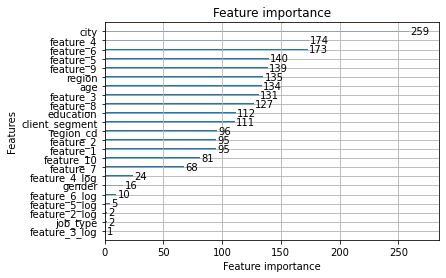

In [112]:
feature_importance = pd.DataFrame(np.array([list(X.columns),model.feature_importances_]).T)
feature_importance.columns = ['column', 'importance']
feature_importance['importance'] = feature_importance['importance'].map(int)
feature_importance.sort_values(by='importance', ascending = False).iloc[:20, 0].values

In [113]:
if USE_WANDB:
    wandb.run.summary["validation_accuracy"] = validation_accuracy
    wandb.run.summary["anic"] = 1/3*public_score+ 2/3 * private_score

In [114]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [115]:
make_submission = True

In [116]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [117]:
if make_submission:
    public_anic = float(input())
    wandb.run.summary["public_anic"] = public_anic

In [118]:
if USE_WANDB:
    run.finish()